# Pose anomaly detection

## Install requirements
``` pip install -r requirements.txt ```

## Convert videos to frames

In [ ]:
import os

import cv2
# path to video
vc = cv2.VideoCapture(str('data/videos/Fighting/Fighting032_x264.mp4'))
c = 1
# path to frames
save_path_dir = 'data/videos/Fighting/Fighting032_x264'
os.system(f'mkdir {save_path_dir}')
if vc.isOpened():
    rval, frame = vc.read()
else:
    rval = False
while rval:
    try:
        rval, frame = vc.read()
        cv2.imwrite(f'{save_path_dir}/frame-%04d.jpg' % c, frame)
        c = c + 1
        cv2.waitKey(1)
    except Exception as e:
        print(e)
vc.release()

##  Install AlphaPose 
### AlphaPose is an accurate multi-person pose estimator
By link: https://github.com/Amanbhandula/AlphaPose

## Run AlpaPose 
### pose tracking 
AlphaPose/demo.py

```python3 demo.py --indir ${img_directory} --outdir ${out_dir} ```

This will generate json file 
Look at : AlphaPose/doc/output.md

### Import dependencies

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from pathlib import Path
import numpy as np 
import pandas as pd
pd.options.mode.chained_assignment = None

### Convert json to csv using pandas DataFrame and add person id column 

In [28]:
df = pd.read_json('data/videos/Fighting/Fighting032_x264/alphapose-results.json')
#Get int id from  image_id column
df.image_id = df.image_id.apply(lambda x: x[6:-4])
df.image_id = df.image_id.astype(int)
#Get key points as numpy array 
key_points = np.array(df.keypoints.to_list())
df2 = pd.DataFrame(key_points)
df2['image_id'] = df.image_id
df2['score'] = df.score
df2 = df2.sort_values(by = ['image_id'])
#Get person id and add in DataFrame
output_df = pd.DataFrame()
for im in df2.image_id.unique():
    image_df = df2[df2.image_id == im]
    person_list = [i for i in range(len(image_df))]
    image_df['person'] = person_list
    output_df = output_df.append(image_df)
output_df.to_csv('data/features/Fighting032_x264.csv', index=False)
output_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,image_id,score,person
1035,297.306702,99.996819,0.102870,298.551971,98.004387,0.093190,296.061401,98.253441,0.078872,302.536835,...,0.002012,292.823700,117.928741,0.012129,293.072754,116.185364,0.082195,9,0.597755,0
2200,298.104706,100.636337,0.180640,299.516968,98.988686,0.169255,296.927795,99.224060,0.183657,302.812256,...,0.001906,296.457031,97.576408,0.004590,293.397125,115.229836,0.053618,11,0.631115,0
2434,297.915070,101.162857,0.158724,298.619385,99.049927,0.129762,296.271667,99.284698,0.141153,302.845245,...,0.001305,292.984894,116.892479,0.006556,292.984894,116.188164,0.015257,12,0.736130,0
1972,296.217621,100.349976,0.093805,297.727600,98.588348,0.087348,294.959320,98.840012,0.062892,302.509155,...,0.001722,293.197693,117.211250,0.004465,293.197693,116.204605,0.064510,14,0.739572,0
2092,295.811157,100.567238,0.149141,297.832336,98.798691,0.126491,294.547882,98.798691,0.092573,302.127380,...,0.001782,292.779358,118.252716,0.004548,292.779358,115.978867,0.045881,15,0.687226,0


## Processing DataFrame and get outliers

### Read csv data which must include additional column 'person' 

In [43]:
data_folder = Path("data/features")
df = pd.read_csv(data_folder / 'Fighting032_x264.csv')
df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,image_id,score,person
0,297.306702,99.996819,0.102870,298.551971,98.004387,0.093190,296.061401,98.253441,0.078872,302.536835,...,0.002012,292.823700,117.928741,0.012129,293.072754,116.185364,0.082195,9,0.597755,0
1,298.104706,100.636337,0.180640,299.516968,98.988686,0.169255,296.927795,99.224060,0.183657,302.812256,...,0.001906,296.457031,97.576408,0.004590,293.397125,115.229836,0.053618,11,0.631115,0
2,297.915070,101.162857,0.158724,298.619385,99.049927,0.129762,296.271667,99.284698,0.141153,302.845245,...,0.001305,292.984894,116.892479,0.006556,292.984894,116.188164,0.015257,12,0.736130,0
3,296.217621,100.349976,0.093805,297.727600,98.588348,0.087348,294.959320,98.840012,0.062892,302.509155,...,0.001722,293.197693,117.211250,0.004465,293.197693,116.204605,0.064510,14,0.739572,0
4,295.811157,100.567238,0.149141,297.832336,98.798691,0.126491,294.547882,98.798691,0.092573,302.127380,...,0.001782,292.779358,118.252716,0.004548,292.779358,115.978867,0.045881,15,0.687226,0


1. `keypoints` [0,1,...,50]  contains the body part locations and detection confidence formatted as `x1 - 0,y1 - 1,c1 - 3,...`. `c` is the confidence score in the range [0,1].
2. `score` is the confidence score for the whole person, computed by our parametric pose NMS.
3. `image_id` is number of video frame.
4. `person` is person id in frame.

## Drop high correlation columns

The columns which high correlated with each other have no sense for model.

So we as optional can drop it using corr_val threshold

In [44]:
def corr_df(df, corr_val):
    '''
    Obj: Drops features that are strongly correlated to other features.
          This lowers model complexity, and aids in generalizing the model.
    Inputs:
          df: features df
          corr_val: Columns are dropped relative to the corr_val input (e.g. 0.8)
    Output: df that only includes uncorrelated features
    '''
    categorical_subset = df[['image_id', 'person']]
    df = df.drop(columns=['image_id', 'person'], axis=1)
    # Creates Correlation Matrix and Instantiates
    corr_matrix = df.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterates through Correlation Matrix Table to find correlated columns
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j + 1), (i + 1):(i + 2)]
            col = item.columns
            row = item.index
            val = item.values
            if val >= corr_val:
                # Prints the correlated feature set and the corr val
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(i)

    drops = sorted(set(drop_cols))[::-1]

    # Drops the correlated columns
    for i in drops:
        col = df.iloc[:, (i + 1):(i + 2)].columns.values
        df = df.drop(columns=col, axis=1)

    df = pd.concat([df, categorical_subset], axis=1)
    return df

corr_val = 0.99
df = corr_df(df, corr_val)
df.head(5)

3 | 0 | 0.99
6 | 0 | 0.99
6 | 3 | 0.99
9 | 0 | 0.99
9 | 3 | 0.99
12 | 0 | 0.99
12 | 6 | 0.99
15 | 9 | 0.99
18 | 12 | 1.0
21 | 15 | 0.99
24 | 18 | 0.99
33 | 15 | 0.99
36 | 12 | 0.99
36 | 18 | 0.99


,0,1,2,4,5,7,8,10,11,13,...,44,45,46,47,48,49,50,score,image_id,person
0,297.306702,99.996819,0.102870,98.004387,0.093190,98.253441,0.078872,98.751549,0.194407,99.249657,...,0.002012,292.823700,117.928741,0.012129,293.072754,116.185364,0.082195,0.597755,9,0
1,298.104706,100.636337,0.180640,98.988686,0.169255,99.224060,0.183657,98.753304,0.173380,99.930199,...,0.001906,296.457031,97.576408,0.004590,293.397125,115.229836,0.053618,0.631115,11,0
2,297.915070,101.162857,0.158724,99.049927,0.129762,99.284698,0.141153,98.815155,0.181443,100.458549,...,0.001305,292.984894,116.892479,0.006556,292.984894,116.188164,0.015257,0.736130,12,0
3,296.217621,100.349976,0.093805,98.588348,0.087348,98.840012,0.062892,98.840012,0.174230,99.846649,...,0.001722,293.197693,117.211250,0.004465,293.197693,116.204605,0.064510,0.739572,14,0
4,295.811157,100.567238,0.149141,98.798691,0.126491,98.798691,0.092573,99.051338,0.252890,99.556633,...,0.001782,292.779358,118.252716,0.004548,292.779358,115.978867,0.045881,0.687226,15,0


### Aggregate n-rows to one row-vector. 
Which helps us to avoid local anomalies. 

For example, an error in the operation of the AlphaPose algorithm or a jittering frame.

In [45]:
n = 10
categorical_subset = df[['image_id', 'person']]
df.drop(columns=['image_id', 'person'], axis=1, inplace=True)
expanded = []
for row in df.iterrows():
    bunch = df.loc[row[0]:row[0]+n].values
    bunch_flat = bunch.flatten()
    expanded.append(bunch_flat)
columns = [i for i in range(len(expanded[0]))]
expanded_df = pd.DataFrame(data=expanded, columns=columns)
df = pd.concat([expanded_df, categorical_subset], axis=1)

df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,454,455,456,457,458,459,460,461,image_id,person
0,297.306702,99.996819,0.102870,98.004387,0.093190,98.253441,0.078872,98.751549,0.194407,99.249657,...,0.001176,185.300369,99.091003,0.006208,177.347198,106.698387,0.003270,0.793295,9,0
1,298.104706,100.636337,0.180640,98.988686,0.169255,99.224060,0.183657,98.753304,0.173380,99.930199,...,0.002514,181.755005,97.597069,0.004451,177.704300,106.711143,0.004430,1.079979,11,0
2,297.915070,101.162857,0.158724,99.049927,0.129762,99.284698,0.141153,98.815155,0.181443,100.458549,...,0.002423,186.654404,100.069527,0.004002,188.025848,99.040939,0.003124,0.941101,12,0
3,296.217621,100.349976,0.093805,98.588348,0.087348,98.840012,0.062892,98.840012,0.174230,99.846649,...,0.002402,186.641663,100.197792,0.004022,188.015778,99.167206,0.003137,0.942489,14,0
4,295.811157,100.567238,0.149141,98.798691,0.126491,98.798691,0.092573,99.051338,0.252890,99.556633,...,0.005710,187.608688,98.852150,0.003151,178.074585,106.683739,0.003489,0.999742,15,0


## Log transformation

Log transformation is a data transformation method in which it expands each variable x with a log(x).

The log transformation reduces or removes the skewness of our original data 
and helps model detect non-linear dependencies between variables.

This part will aggregate each existing row with row which have transformed.

In [46]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
# Obj: Creates columns with log of numeric columns
categorical_subset = df[['image_id', 'person']].astype(int)
df.drop(columns=['image_id', 'person'], axis=1, inplace=True)
numeric_subset = df.select_dtypes('number')
for col in numeric_subset.columns:
    if col == 'image_id' or col == 'person':
        continue
    else:
        numeric_subset['log_' + str(col)] = np.log(numeric_subset[col])
df = pd.concat([numeric_subset, categorical_subset], axis=1)

df[[0, 'log_0', 1, 'log_1']].head(5)


,0,log_0,1,log_1
0,297.306702,5.694764,99.996819,4.605138
1,298.104706,5.697445,100.636337,4.611513
2,297.915070,5.696808,101.162857,4.616732
3,296.217621,5.691094,100.349976,4.608664
4,295.811157,5.689721,100.567238,4.610827


## Detect outliers

This is the main part which returns list of outliers. Where (-1) is outliers.

Isolation forest is an unsupervised learning algorithm for anomaly detection that works 
on the principle of isolating anomalies, instead of the most common techniques of profiling normal points.


In [47]:
def outlier_detection_ISOFOREST(df):
    df = df.fillna(0)
    clf = IsolationForest()
    outliers = clf.fit_predict(df)
    print(list(outliers).count(-1))
    return outliers

outliers = outlier_detection_ISOFOREST(df)
print(outliers)
df['outliers'] = outliers

180
[ 1  1  1 ... -1 -1 -1]


## Plotting

Here we have to set frame_id as index.

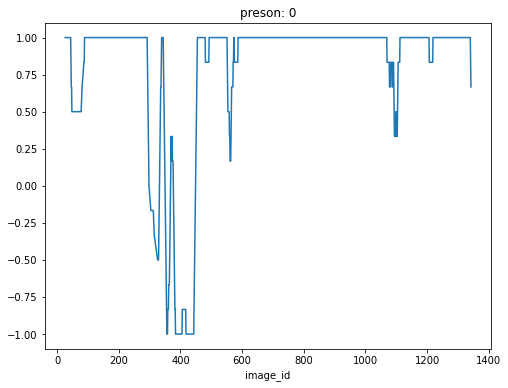

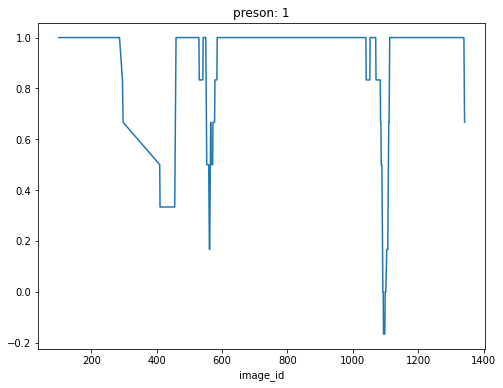

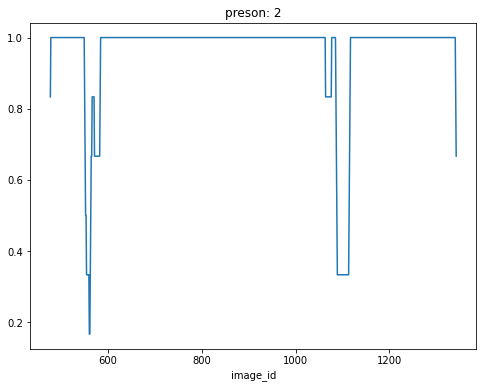

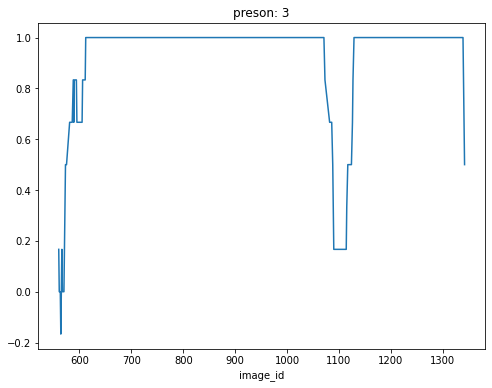

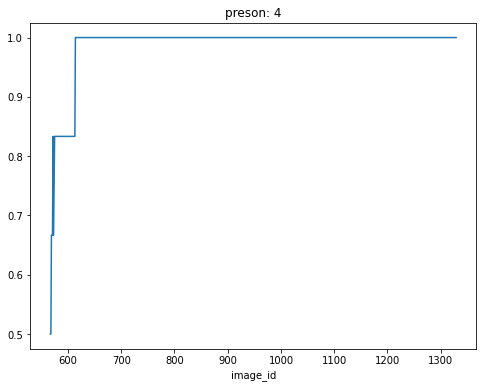

In [48]:
def plotting_outliers(df, outliers):
    mpl.rcParams['figure.figsize'] = (8, 6)
    mpl.rcParams['axes.grid'] = False
    # Smooth outliers (rolling window)
    _ = df['outliers'].rolling(window=12).mean().plot()
    
    plt.show()
df.index = df.image_id

for person_id in df.person.unique():
    person_df = df[df.person==person_id]
    if len(person_df) < 50: continue
    plt.title(f'preson: {person_id}')
    plotting_outliers(person_df, outliers)

## Next steps

Main idea for detecting outliers is compare normal behaviour with abnormal.

So if we DON'T want to get outliers from normal behavior video,
we have to aggregate two type of videos (normal, abnormal) as one.
And then compare our reference video with new in which we wanna process.

## Additional step

Representation of the pose in Euclidean space and normalization of the angles between the limbs.

